In [1]:
!pip install tensorflow-recommenders

  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.13.0
    Uninstalling absl-py-0.13.0:
      Successfully uninstalled absl-py-0.13.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully unins

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.2.0 requires tensorboard<2.3.0,>=2.2.0, but you have tensorboard 2.10.1 which is incompatible.
spektral 1.0.8 requires numpy<1.20, but you have numpy 1.23.2 which is incompatible.


In [2]:
!pip install scann

ERROR: Could not find a version that satisfies the requirement scann
ERROR: No matching distribution found for scann


In [3]:
import os
import pprint
import tempfile
import pandas as pd
from typing import Dict, Text

import numpy as np
import tensorflow as tf

In [4]:
df = pd.read_csv('amazon_product_beer.csv')
df

,brewery_id,score,username,text,style,abv,brewery_name,beer_name
0,10325,1.5,stcules,My Favorite White Wine,Hefeweizen,5.0,Vecchio Birraio,Sausa Weizen
1,10325,3.0,stcules,Yum!!,English Strong Ale,6.2,Vecchio Birraio,Red Moon
2,10325,3.0,stcules,A New Favorite!,Foreign / Export Stout,6.5,Vecchio Birraio,Black Horse Black Beer
3,10325,3.0,stcules,"Bold, Flavorful, Aromatic, Delicious",German Pilsener,5.0,Vecchio Birraio,Sausa Pils
4,1075,4.0,johnmichaelsen,"Yum! Plus, Environmentally Friendly!",American Double / Imperial IPA,7.7,Caldera Brewing Company,Cauldron DIPA
...,...,...,...,...,...,...,...,...
2841,14879,4.0,goblue3509,Excellent,American Double / Imperial IPA,10.0,Hoppin' Frog Brewery,Hop Dam Triple IPA
2842,14879,4.0,heysuz,Delicious !!,American Double / Imperial IPA,10.0,Hoppin' Frog Brewery,Hop Dam Triple IPA
2843,14879,4.0,BeerWanker,Sumptuous delicious wine.,American Double / Imperial IPA,10.0,Hoppin' Frog Brewery,Hop Dam Triple IPA
2844,14879,1.5,PittBeerGirl,Excellent Moscato,American Double / Imperial IPA,10.0,Hoppin' Frog Brewery,Hop Dam Triple IPA


In [6]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [10]:
import matplotlib.pyplot as plt

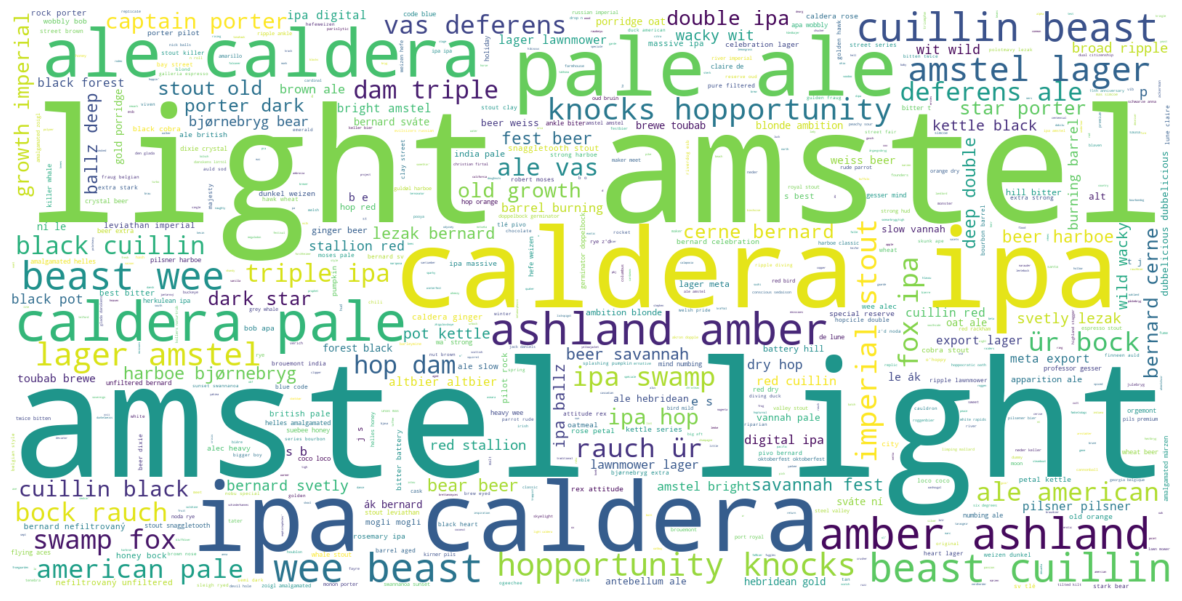

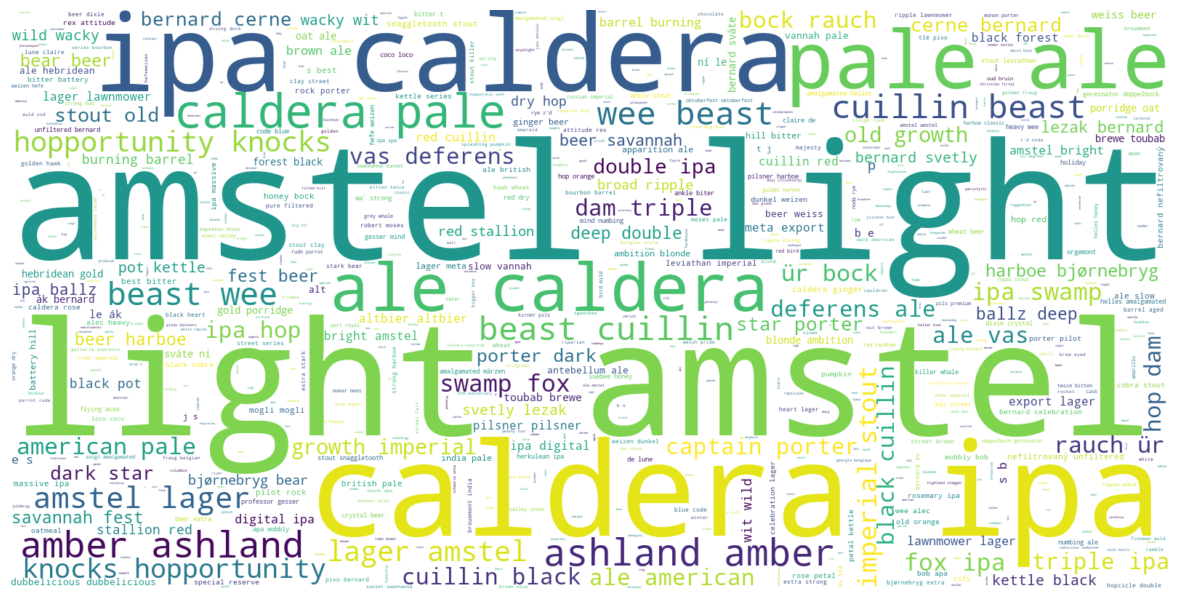

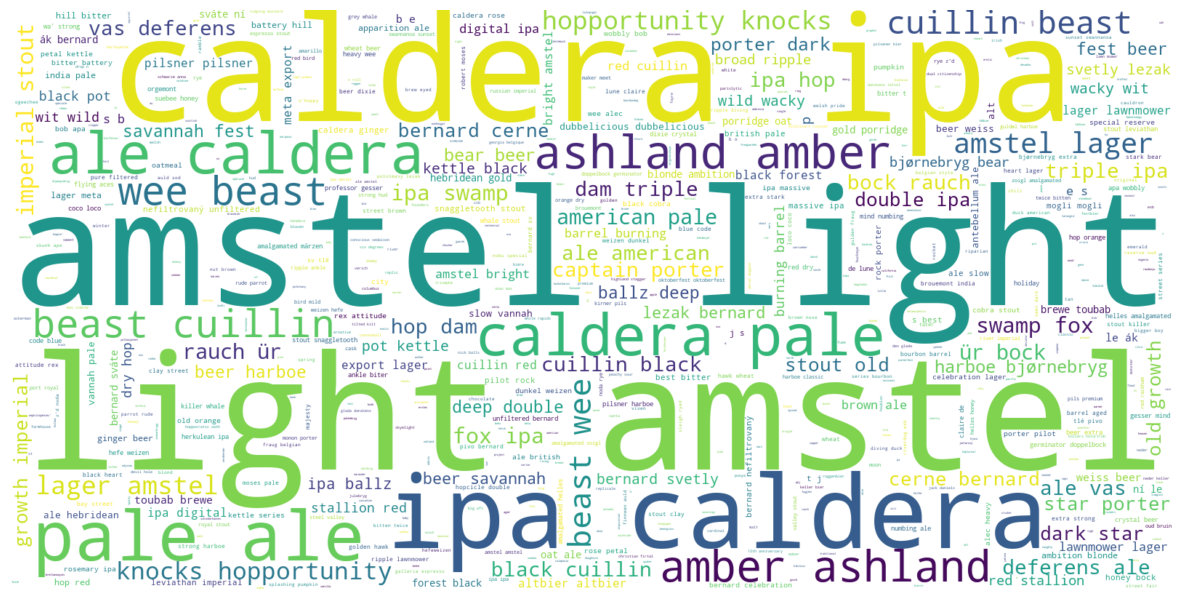

In [12]:
word_string1 = " ".join(df['beer_name'].str.lower())
plt.figure(figsize=(15,15))
wc = WordCloud(background_color="white", stopwords=STOPWORDS, max_words=2000, max_font_size=300, width=1600, height=800)
wc.generate(word_string1)

plt.imshow(wc.recolor(colormap='viridis', random_state=17), interpolation="bilinear")
plt.axis('off')
plt.show()


In [13]:
print("User A reviews")
df[df['username']=='stcules'].head()

User A reviews


,brewery_id,score,username,text,style,abv,brewery_name,beer_name
0,10325,1.5,stcules,My Favorite White Wine,Hefeweizen,5.0,Vecchio Birraio,Sausa Weizen
1,10325,3.0,stcules,Yum!!,English Strong Ale,6.2,Vecchio Birraio,Red Moon
2,10325,3.0,stcules,A New Favorite!,Foreign / Export Stout,6.5,Vecchio Birraio,Black Horse Black Beer
3,10325,3.0,stcules,"Bold, Flavorful, Aromatic, Delicious",German Pilsener,5.0,Vecchio Birraio,Sausa Pils
1508,16604,4.0,stcules,Perfect for thieving beer from unsuspecting fe...,Munich Dunkel Lager,NaN,Landhausbräu Koller,Kollers Naturtrüb Dunkel


In [15]:
df_beer = df['beer_name'].unique()
df_beer = pd.DataFrame(df_beer, columns = ['beer_name'])

df_ratings = df[['username', 'beer_name']]
df_ratings = df_ratings.dropna()
tf_beer_dict = tf.data.Dataset.from_tensor_slices(dict(df_beer))
tf_ratings_dict = tf.data.Dataset.from_tensor_slices(dict(df_ratings))

In [16]:
df_ratings

,username,beer_name
0,stcules,Sausa Weizen
1,stcules,Red Moon
2,stcules,Black Horse Black Beer
3,stcules,Sausa Pils
4,johnmichaelsen,Cauldron DIPA
...,...,...
2841,goblue3509,Hop Dam Triple IPA
2842,heysuz,Hop Dam Triple IPA
2843,BeerWanker,Hop Dam Triple IPA
2844,PittBeerGirl,Hop Dam Triple IPA


In [17]:
ratings = tf_ratings_dict.map(lambda x:{"beer_name":x["beer_name"],
                                       "username":x["username"]
                                       })
beer_list = tf_beer_dict.map(lambda x: x['beer_name'])

In [18]:
usernames=ratings.map(lambda x:x['username'])

In [19]:
unique_users = np.unique(np.concatenate(list(usernames.batch(1000))))
unique_beers = np.unique(np.concatenate(list(beer_list.batch(1000))))

In [20]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(len(df), seed=42, reshuffle_each_iteration=False)
                          
train = shuffled.take(int(len(df)*0.8))
test = shuffled.skip(int(len(df)*0.8)).take(int(len(df)*0.2))

In [21]:
%load_ext tensorboard

In [23]:
import tensorflow_recommenders as tfrs

In [24]:

class AmazonProduct(tfrs.Model):
    def __init__(self):
        super().__init__()

    
        embedding_dims = 32
        

        self.user_model =  tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary= unique_users, mask_token=None),
            tf.keras.layers.Embedding(len(unique_users)+1, embedding_dims)
        ])
    
    


        self.beer_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_beers, mask_token=None),
            tf.keras.layers.Embedding(len(unique_beers)+1, embedding_dims)
        ])

        self.task = tfrs.tasks.Retrieval(
                        metrics=tfrs.metrics.FactorizedTopK(
                        candidates=beer_list.batch(128).cache().map(self.beer_model)
                        ))
      
    
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features['username'])
        beer_embeddings = self.beer_model(features['beer_name'])
        return self.task(user_embeddings, beer_embeddings)
        

In [29]:
import datetime
import keras

In [30]:
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
model=AmazonProduct()
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

In [32]:
freq = 2
epochs = 20

history = model.fit(
    
                train.batch(8192),
                validation_data= test.batch(512),
                validation_freq=freq,
                epochs = epochs,
                verbose = 0,
                callbacks=[tensorboard_callback])

In [33]:
%tensorboard --logdir logs/fit

In [34]:
model.evaluate(test.batch(8192), return_dict=True)

1/1 [==============================] - 0s 66ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0035 - factorized_top_k/top_5_categorical_accuracy: 0.0299 - factorized_top_k/top_10_categorical_accuracy: 0.0879 - factorized_top_k/top_50_categorical_accuracy: 0.3111 - factorized_top_k/top_100_categorical_accuracy: 0.4534 - loss: 4762.9502 - regularization_loss: 0.0000e+00 - total_loss: 4762.9502


{'factorized_top_k/top_1_categorical_accuracy': 0.003514938522130251,
 'factorized_top_k/top_5_categorical_accuracy': 0.02987697720527649,
 'factorized_top_k/top_10_categorical_accuracy': 0.08787345886230469,
 'factorized_top_k/top_50_categorical_accuracy': 0.31107205152511597,
 'factorized_top_k/top_100_categorical_accuracy': 0.4534270763397217,
 'loss': 4762.9501953125,
 'regularization_loss': 0,
 'total_loss': 4762.9501953125}

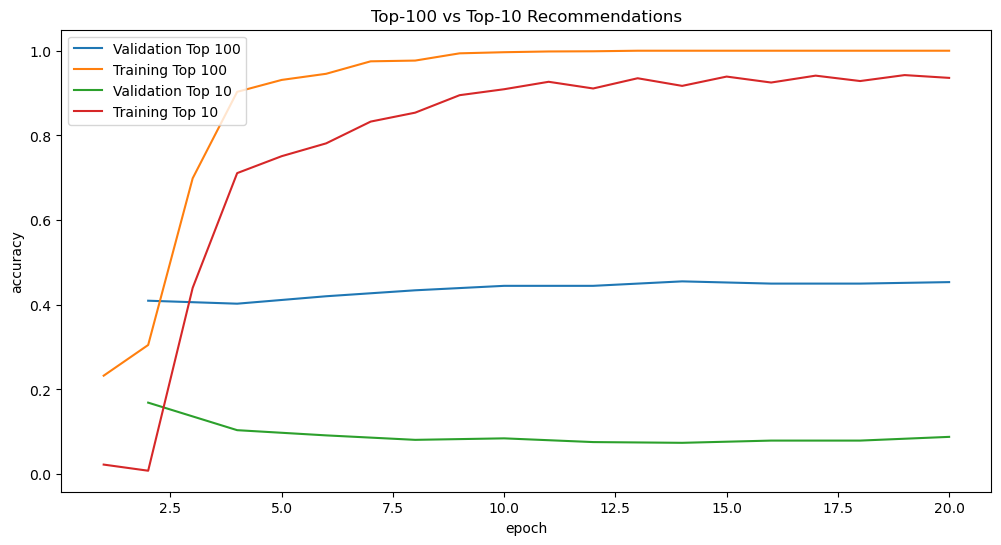

In [35]:
plt.figure(figsize=(12,6))
num_validation_runs = len(history.history["val_factorized_top_k/top_10_categorical_accuracy"])
epochs = [(x + 1)* freq for x in range(num_validation_runs)]

plt.plot(epochs, history.history["val_factorized_top_k/top_100_categorical_accuracy"], label = "Validation Top 100")
plt.plot(np.linspace(1, len( history.history["factorized_top_k/top_100_categorical_accuracy"]), 
                     len( history.history["factorized_top_k/top_100_categorical_accuracy"])),
                     history.history["factorized_top_k/top_100_categorical_accuracy"], label = "Training Top 100")
plt.plot(epochs, history.history["val_factorized_top_k/top_10_categorical_accuracy"], label = "Validation Top 10")
plt.plot(np.linspace(1, len( history.history["factorized_top_k/top_10_categorical_accuracy"]), 
                     len( history.history["factorized_top_k/top_10_categorical_accuracy"])),
                     history.history["factorized_top_k/top_10_categorical_accuracy"], label = "Training Top 10")
plt.title("Top-100 vs Top-10 Recommendations")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [36]:
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(beer_list.batch(128).map(lambda beer_name: (beer_name, model.beer_model(beer_name))))

In [37]:
_,titles= index(tf.constant(["stcules"]))

print(f"Recommendations for user stcules: {titles[0, :10]}")

Recommendations for user stcules: [b'Kollers Naturtr\xc3\xbcb Hell' b'Red Moon' b'Sausa Weizen'
 b'Kollers Naturtr\xc3\xbcb Dunkel' b'Sausa Pils'
 b'Bernard Nefiltrovan\xc3\xbd (unfiltered)' b'Black Cuillin'
 b'Brew Eyed Blond' b'City Pale Ale' b'Brown Nose Ale']
